In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

file_path = '/content/drive/MyDrive/Patient_information_cleaned.csv'
df = pd.read_csv(file_path)


In [3]:
df.shape

(64124, 23)

In [4]:
disp_map = df.dropna(subset=['DISCH_DISP', 'DISCH_DISP_C']).set_index('DISCH_DISP_C')['DISCH_DISP']

df['DISCH_DISP'] = df.apply(lambda row: disp_map.get(row['DISCH_DISP_C']) if pd.isna(row['DISCH_DISP']) else row['DISCH_DISP'], axis=1)

reverse_disp_map = df.dropna(subset=['DISCH_DISP', 'DISCH_DISP_C']).set_index('DISCH_DISP')['DISCH_DISP_C']
df['DISCH_DISP_C'] = df.apply(lambda row: reverse_disp_map.get(row['DISCH_DISP']) if pd.isna(row['DISCH_DISP_C']) else row['DISCH_DISP_C'], axis=1)
df.dropna(subset=['DISCH_DISP', 'DISCH_DISP_C'], how='all', inplace=True)



In [5]:
disp_map = df.dropna(subset=['ASA_RATING', 'ASA_RATING_C']).set_index('ASA_RATING_C')['ASA_RATING']

df['ASA_RATING'] = df.apply(lambda row: disp_map.get(row['ASA_RATING_C']) if pd.isna(row['ASA_RATING']) else row['ASA_RATING'], axis=1)

reverse_disp_map = df.dropna(subset=['ASA_RATING', 'ASA_RATING_C']).set_index('ASA_RATING')['ASA_RATING_C']
df['ASA_RATING'] = df.apply(lambda row: reverse_disp_map.get(row['ASA_RATING']) if pd.isna(row['ASA_RATING_C']) else row['ASA_RATING_C'], axis=1)

df.dropna(subset=['ASA_RATING', 'ASA_RATING_C'], how='all', inplace=True)



In [6]:
df_new = df.drop(columns=["LOG_ID","MRN","DISCH_DISP","SURGERY_DATE","PRIMARY_ANES_TYPE_NM","ASA_RATING","PATIENT_CLASS_GROUP","PATIENT_CLASS_NM","PRIMARY_PROCEDURE_NM","PRIMARY_PROCEDURE_NM_ENCODED"])

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


columns_to_use = ['DISCH_DISP_C', 'LOS', 'ASA_RATING_C', 'PATIENT_CLASS_GROUP_ENCODED', 'SEX']
X = df_new[columns_to_use]
y = df_new['ICU_ADMIN_FLAG']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    'C': [0.1,0.01,10,1],
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_log_reg = grid_search.best_estimator_

y_pred = best_log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Optimized Logistic Regression Accuracy: {accuracy:.4f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Optimized Logistic Regression Accuracy: 0.8176
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      6484
           1       0.77      0.83      0.80      5073

    accuracy                           0.82     11557
   macro avg       0.82      0.82      0.82     11557
weighted avg       0.82      0.82      0.82     11557

Confusion Matrix:
 [[5225 1259]
 [ 849 4224]]


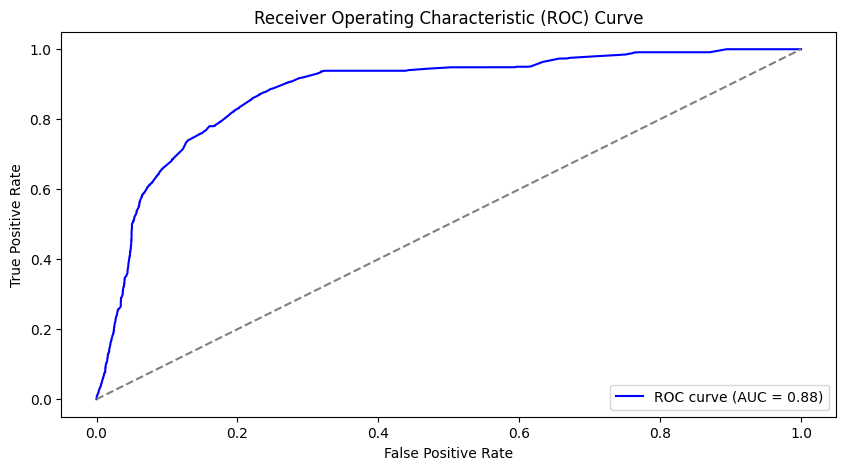

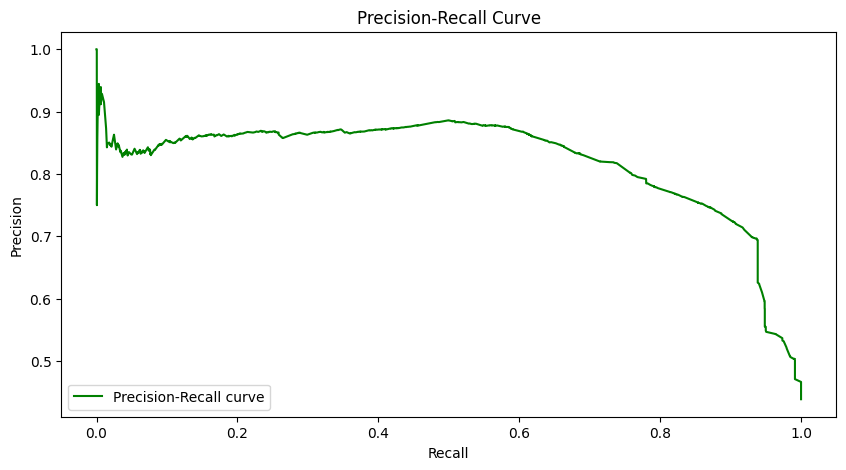

Confusion Matrix:
 [[5225 1259]
 [ 849 4224]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      6484
           1       0.77      0.83      0.80      5073

    accuracy                           0.82     11557
   macro avg       0.82      0.82      0.82     11557
weighted avg       0.82      0.82      0.82     11557



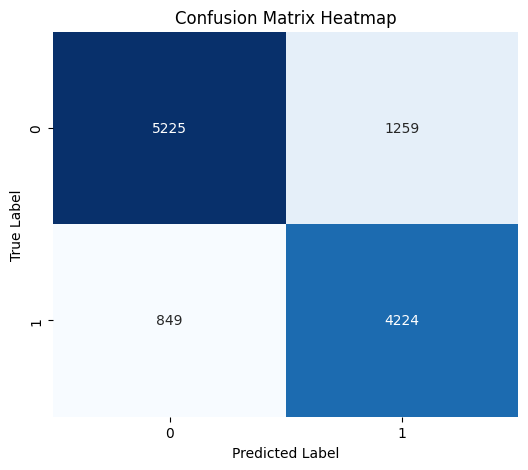

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay

# Assuming y_test and y_pred are available, and best_svm has been trained

# Predict probabilities for ROC and AUC
y_prob = best_svm.decision_function(X_test)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix with a heatmap
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


Logistic Regression Accuracy: 0.8162
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      6484
           1       0.77      0.83      0.80      5073

    accuracy                           0.82     11557
   macro avg       0.81      0.82      0.81     11557
weighted avg       0.82      0.82      0.82     11557

Confusion Matrix:
 [[5212 1272]
 [ 852 4221]]


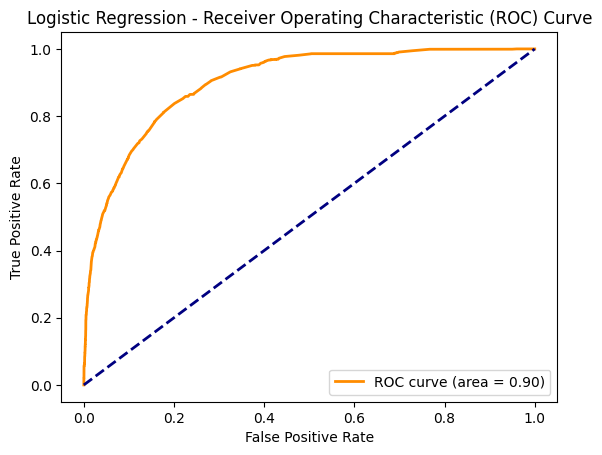

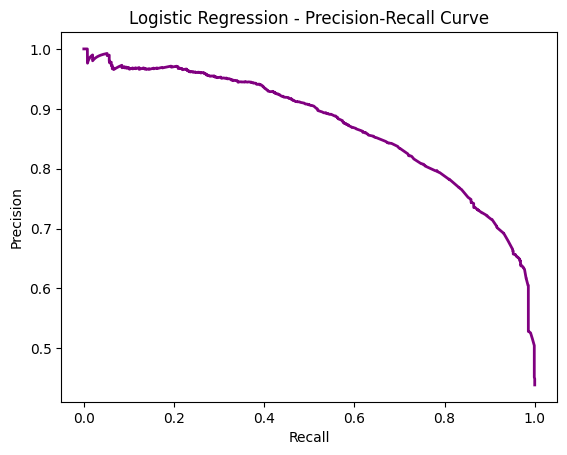

Random Forest Accuracy: 0.8156
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      6484
           1       0.77      0.82      0.80      5073

    accuracy                           0.82     11557
   macro avg       0.81      0.82      0.81     11557
weighted avg       0.82      0.82      0.82     11557

Confusion Matrix:
 [[5264 1220]
 [ 911 4162]]


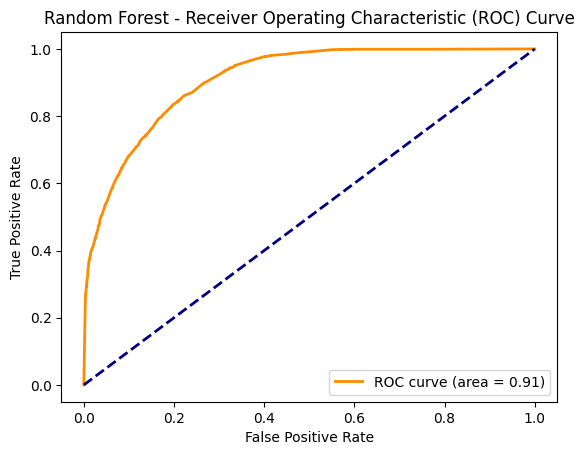

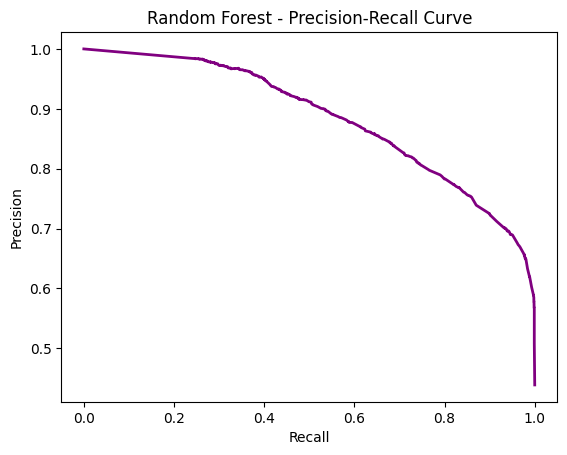

Gradient Boosting Accuracy: 0.8194
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      6484
           1       0.78      0.82      0.80      5073

    accuracy                           0.82     11557
   macro avg       0.82      0.82      0.82     11557
weighted avg       0.82      0.82      0.82     11557

Confusion Matrix:
 [[5285 1199]
 [ 888 4185]]


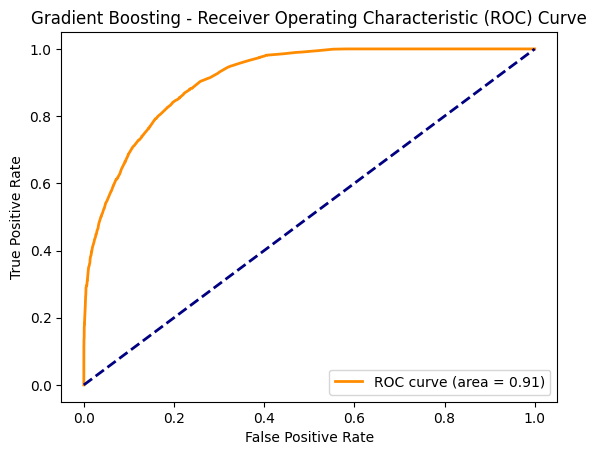

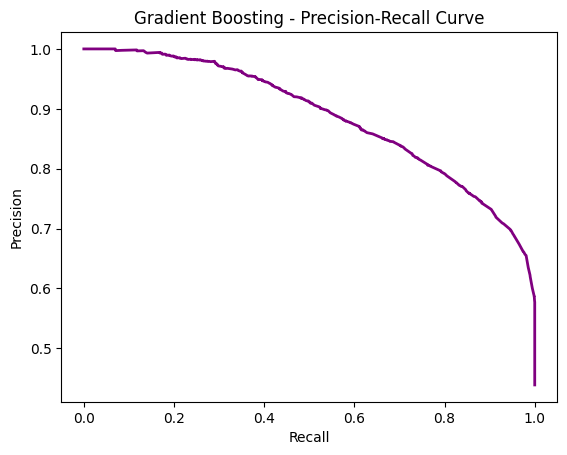

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

columns_to_use = ['DISCH_DISP_C', 'LOS', 'ASA_RATING_C', 'PATIENT_CLASS_GROUP_ENCODED', 'SEX']
X = df_new[columns_to_use]
y = df_new['ICU_ADMIN_FLAG']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.4f}')
    print("Classification Report:\n", classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.show()


# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42)
evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression")

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# 3. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting")